In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.chdir('C:/Users/SSAFY/Desktop/SSAFY/projects/PJT1/AI/')
CODE_DIR = 'VToonify'
device = 'cpu'
# device = 'cuda'

!pip install faiss-cpu
!pip install wget

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force 

In [2]:
os.chdir(f'./{CODE_DIR}')
MODEL_DIR = os.path.join(os.path.dirname(os.getcwd()), CODE_DIR, 'checkpoint')
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), CODE_DIR, 'data')
OUT_DIR = os.path.join(os.path.dirname(os.getcwd()), CODE_DIR, 'output')

In [3]:
print(os.environ.get('CUDA_PATH'))

C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.7


In [4]:
ls

 C 드라이브의 볼륨: Windows10
 볼륨 일련 번호: DC54-A099

 C:\Users\SSAFY\Desktop\SSAFY\projects\PJT1\AI\VToonify 디렉터리

2023-01-19  오후 04:55    <DIR>          .
2023-01-19  오후 04:55    <DIR>          ..
2023-01-19  오후 03:27    <DIR>          __pycache__
2023-01-25  오후 04:25    <DIR>          checkpoint
2023-01-25  오후 05:42    <DIR>          data
2023-01-17  오후 04:27    <DIR>          environment
2023-01-17  오후 04:27             1,697 LICENSE.md
2023-01-19  오후 12:59    <DIR>          model
2023-01-17  오후 04:27    <DIR>          notebooks
2023-01-25  오후 05:39    <DIR>          output
2023-01-17  오후 04:27            20,104 README.md
2023-01-17  오후 04:27             6,419 smooth_parsing_map.py
2023-01-17  오후 04:27            12,302 style_transfer.py
2023-01-17  오후 04:27            23,923 train_vtoonify_d.py
2023-01-17  오후 04:27            19,614 train_vtoonify_t.py
2023-01-17  오후 04:27             7,829 util.py
2023-01-17  오후 04:27            15,369 vtoonify_model.py
               8개 파일             10

In [5]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

import sys
sys.path.append(".")
sys.path.append("..")

# ========================================================
import glob # 사진 보기용
import time # time 라이브러리 import
# ========================================================

import argparse
import numpy as np
import cv2
import dlib
import torch
from torchvision import transforms
import torchvision
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from model.vtoonify import VToonify
from model.bisenet.model import BiSeNet
from model.encoder.align_all_parallel import align_face
from util import save_image, load_image, visualize, load_psp_standalone, get_video_crop_parameter, tensor2cv2

In [6]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [7]:
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory ../checkpoint/. """
    current_directory = os.getcwd()
    save_path = MODEL_DIR
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    print("저장 경로 ===================== {SAVE_PATH}/{FILE_NAME}".format(FILE_NAME=file_name, SAVE_PATH=save_path))
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path) # -O 옵션 : 저장하는 파일 이름 지정
    return url

MODEL_PATHS = {
    "encoder": {"id": "1NgI4mPkboYvYw3MWcdUaQhkr0OWgs9ej", "name": "encoder.pt"},
    "faceparsing": {"id": "1jY0mTjVB8njDh6e0LP_2UxuRK3MnjoIR", "name": "faceparsing.pth"},
    "arcane_exstyle": {"id": "1TC67wRJkdmNRZTqYMUEFkrhWRKKZW40c", "name": "exstyle_code.npy"},
    "caricature_exstyle": {"id": "1xr9sx_WmRYJ4qHGTtdVQCSxSo4HP3-ip", "name": "exstyle_code.npy"},
    "cartoon_exstyle": {"id": "1BuCeLk3ASZcoHlbfT28qNru4r5f-hErr", "name": "exstyle_code.npy"},
    "pixar_exstyle": {"id": "1yTaKuSrL7I0i0RYEEK5XD6GI-y5iNUbj", "name": "exstyle_code.npy"}, 
    "arcane000": {"id": "1pF4fJ8acmawMsjjXo4HXRIOXeZR8jLVh", "name": "generator.pt"},
    "arcane077": {"id": "16rLTF2oC0ZeurnM6hjrfrc8BxtW8P8Qf", "name": "generator.pt"},
    "caricature039": {"id": "1C1E4WEoDWzl0nAxR9okKffFmlMOENbeF", "name": "generator.pt"},
    "caricature068": {"id": "1B1ko1x8fX2aJ4BYCL12AnknVAi3qQc8W", "name": "generator.pt"},
    "cartoon026": {"id": "1YJYODh_vEyUrL0q02okjcicpJhdYY8An", "name": "generator.pt"},
    "cartoon299": {"id": "101qMUMfcI2qDxEbfCBt5mOg2aSqdTaIt", "name": "generator.pt"},
    "pixar052": {"id": "16j_l1x0DD0PjwO8YdplAk69sh3-v95rr", "name": "generator.pt"},
    "cartoon": {"id": "11s0hwhZWTLacMAzZH4OU-o3Qkp54h30J", "name": "generator.pt"},
}

In [8]:
#@title Select a style type { run: "auto", vertical-output: true, display-mode: "both" }
# style_type = "cartoon026" #@param ["cartoon026", "cartoon299", "arcane000", "arcane077", "pixar052", "caricature039", "caricature068", "comic028", "illustration050", "illustration136"]

"""
cartoon026:      beautiful
*cartoon064:      princess-like
*cartoon153:      masculine
cartoon299:      big eyes 
*cartoon008:      handsome
arcane000:       for female 
arcane077:       for male 
pixar052:                
caricature039:   big mouth 
caricature068:   slim  
comic028
illustration050
illustration136


* 항목은 아직 모델파일 없음!
"""


'\ncartoon026:      beautiful\n*cartoon064:      princess-like\n*cartoon153:      masculine\ncartoon299:      big eyes \n*cartoon008:      handsome\narcane000:       for female \narcane077:       for male \npixar052:                \ncaricature039:   big mouth \ncaricature068:   slim  \ncomic028\nillustration050\nillustration136\n\n\n* 항목은 아직 모델파일 없음!\n'

In [9]:
import ipywidgets as widgets

# 스타일 지정
style_type_w = widgets.RadioButtons(
    options=['cartoon026', 'cartoon299', 
             'arcane000', 'arcane077', 
             'pixar052',
             'caricature039','caricature068',
             'comic028',
             'illustration050','illustration136'  ],
   value='pixar052', # Defaults to 'center'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='스타일 지정:',
    disabled=False
)


In [10]:
# 필터 스타일 지정
# style_types = [style_type_w.value, "cartoon026", "cartoon299","illustration050", "comic028", "arcane000"]
# style_types = ['cartoon026', 'cartoon299', 
#              'arcane000', 'arcane077', 
#              'pixar052',
#              'caricature039','caricature068',
#              'comic028',
#              'illustration050','illustration136'  ]
# style_types = ['cartoon026',
#              'arcane000', 
#              'pixar052',
#              'caricature039',
#              'comic028',
#              'illustration050']
style_types = ['cartoon026',
             'arcane000', 
             'pixar052',
             'caricature039',
             'comic028',
             'illustration050']

In [11]:
# target_test = [os.path.join(MODEL_DIR, style_type+'_generator.pt') for style_type in style_types]

In [12]:
# # 파일 크기 조회
# for target in target_test:
#     print(os.path.getsize(target))

In [13]:
# ============================================== 공통 ==============================================
# Compose를 활용하여 여러 개의 transform을 묶을 수 있음
transform = transforms.Compose([
    transforms.ToTensor(), # 이미지를 Pytorch tensors 타입으로 변형
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5,0.5,0.5]), # 텐서를 가져와 평균 및 표준 편차로 정규화함
    ])

parsingpredictor = BiSeNet(n_classes=19)
parsingpredictor.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'faceparsing.pth'), map_location=lambda storage, loc: storage))
# 추론을 실행하기 전에 model.eval()을 호출하여 드롭아웃(dropout)과 배치 정규화 층(batch normalization layers)을 평가(evaluation) 모드로 바꿔야함!
parsingpredictor.to(device).eval() 

modelname = './checkpoint/shape_predictor_68_face_landmarks.dat'
if not os.path.exists(modelname):
    import wget, bz2
    wget.download('http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2', modelname+'.bz2')
    zipfile = bz2.BZ2File(modelname+'.bz2')
    data = zipfile.read()
    open(modelname, 'wb').write(data) 
landmarkpredictor = dlib.shape_predictor(modelname)

pspencoder = load_psp_standalone(os.path.join(MODEL_DIR, 'encoder.pt'), device)   
# =================================================================================================

# 모델 리스트 저장
N = len(style_types)
vtoonify = [VToonify(backbone = 'dualstylegan') for _ in range(N)]
exstyle = [0] * N

start = time.time() # 시작

for i, style_type in enumerate(style_types):
    # 사용하고자 하는 GPU 장치 번호를 지정합니다.
    vtoonify[i].load_state_dict(torch.load(os.path.join(MODEL_DIR, style_type+'_generator.pt'), map_location=lambda storage, loc: storage)['g_ema'])
    print("model file name:",style_type,'generator')
    
    # model.to(torch.device('cuda')) : CUDA에 최적화된 모델로 변환됨
    vtoonify[i].to(device) 
    
    exstyles = np.load(os.path.join(MODEL_DIR, style_type[:-3]+'_exstyle_code.npy'), allow_pickle='TRUE').item()
    stylename = list(exstyles.keys())[int(style_type[-3:])]
    print("style name:", stylename)
    exstyle[i] = torch.tensor(exstyles[stylename]).to(device)
    
    with torch.no_grad():  
        exstyle[i] = vtoonify[i].zplus2wplus(exstyle[i])
    
    print('Model successfully loaded!')

print("=====================================================================================================")
print("학습된 모델 불러오는데 걸리는 시간")
print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

model file name: cartoon026 generator
style name: Cartoons_00167_01.jpg
Model successfully loaded!
model file name: cartoon299 generator
style name: Cartoons_00038_02.jpg
Model successfully loaded!
model file name: arcane000 generator
style name: 1_053_22752.jpg
Model successfully loaded!
model file name: arcane077 generator
style name: 6_173_32688.jpg
Model successfully loaded!
model file name: pixar052 generator
style name: 150_01.png
Model successfully loaded!
model file name: caricature039 generator
style name: Steven_Tyler_C00008.jpg
Model successfully loaded!
model file name: caricature068 generator
style name: Amy_Winehouse_C00009.jpg
Model successfully loaded!
model file name: comic028 generator
style name: 29_01.png
Model successfully loaded!
model file name: illustration050 generator
style name: Tomer_Hanuka-0864.jpg
Model successfully loaded!
model file name: illustration136 generator
style name: Tomer_Hanuka-0616.jpg
Model successfully loaded!
학습된 모델 불러오는데 걸리는 시간
8.0178 sec

In [14]:
input_file_name = "test07.jpg"
image_path = './data/'+input_file_name
original_image = load_image(image_path)

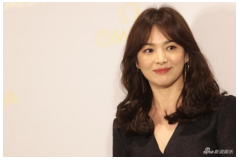

In [15]:
visualize(original_image[0], 30)

In [16]:
# 이미지 전처리

frame = cv2.imread(image_path)
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

scale = 1
kernel_1d = np.array([[0.125],[0.375],[0.375],[0.125]])
# We detect the face in the image, and resize the image so that the eye distance is 64 pixels.
# Centered on the eyes, we crop the image to almost 400x400 (based on args.padding). 
# paras = get_video_crop_parameter(frame, landmarkpredictor, padding=[200,200,200,200]) # => 이렇게 하면 얼굴에 조금 더 초점을 맞추어 자름, 숫자가 클수록 더 넓은 범위의 사진을 처리함
paras = get_video_crop_parameter(frame, landmarkpredictor, padding=[300,300,300,300])
if paras is not None:
    h,w,top,bottom,left,right,scale = paras
    H, W = int(bottom-top), int(right-left)
    # for HR image, we apply gaussian blur to it to avoid over-sharp stylization results
    if scale <= 0.75:
        frame = cv2.sepFilter2D(frame, -1, kernel_1d, kernel_1d)
    if scale <= 0.375:
        frame = cv2.sepFilter2D(frame, -1, kernel_1d, kernel_1d)
    frame = cv2.resize(frame, (w, h))[top:bottom, left:right]
    x = transform(frame).unsqueeze(dim=0).to(device)
else:
    print('no face detected!')

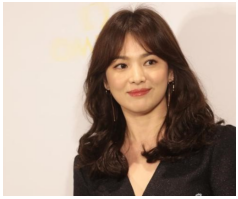

In [17]:
visualize(x[0].cpu(), 30)

In [18]:
start = time.time() # 시작

y_tilde = [0] * N
with torch.no_grad():
    for i in range(N): 
        I = align_face(frame, landmarkpredictor)
        I = transform(I).unsqueeze(dim=0).to(device)
        s_w = pspencoder(I)
        s_w = vtoonify[i].zplus2wplus(s_w)
        s_w[:,:7] = exstyle[i][:,:7]
        # parsing network works best on 512x512 images, so we predict parsing maps on upsmapled frames
        # followed by downsampling the parsing maps
        x_p = F.interpolate(parsingpredictor(2*(F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)))[0], 
                            scale_factor=0.5, recompute_scale_factor=False).detach()
        # we give parsing maps lower weight (1/16)
        inputs = torch.cat((x, x_p/16.), dim=1)
        # d_s has no effect when backbone is toonify
        y_tilde[i] = vtoonify[i](inputs, s_w.repeat(inputs.size(0), 1, 1), d_s = 0.5)        
        y_tilde[i] = torch.clamp(y_tilde[i], -1, 1)
        
print("=====================================================================================================")
print("이미지 변환하는데 걸리는 시간")
print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

이미지 변환하는데 걸리는 시간
195.1728 sec


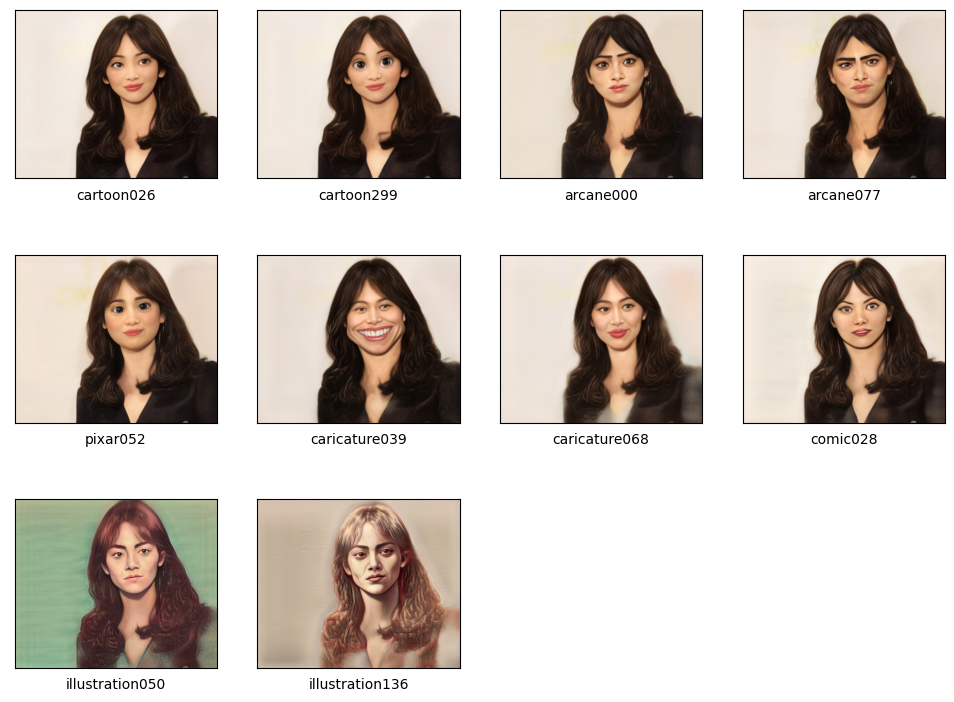

In [19]:
fig = plt.figure(figsize=(12, 9)) # rows*cols 행렬의 i번째 subplot 생성
rows = 3
cols = 4
idx = 1

# 변환된 이미지 저장
result_img = []

for i in range(N): 
#     visualize(y_tilde[i][0].cpu(), 30)
    # 변환한 이미지 저장
    result_img.append(tensor2cv2(y_tilde[i][0].cpu()))
    # '파일이름_스타일타입.jpg' 형식으로 저장
    cv2.imwrite(os.path.join(OUT_DIR, input_file_name[:-4]+'_'+style_types[i]+'.jpg'), result_img[i])

    # 단일 플롯에 다수 이미지 그리기
    ax = fig.add_subplot(rows, cols, idx)
    ax.imshow(cv2.cvtColor(result_img[i], cv2.COLOR_BGR2RGB))
    ax.set_xlabel(style_types[i])
    ax.set_xticks([]), ax.set_yticks([])
    idx += 1
    
plt.show()

In [20]:
# fig = plt.figure() # rows*cols 행렬의 i번째 subplot 생성
# rows = 2
# cols = 2
# i = 1
 
# xlabels = ["xlabel", "(a)", "(b)", "(c)", "(d)"]
 
# for filename in glob.glob("*.jpg"):
#     img = cv2.imread(filename)
#     ax = fig.add_subplot(rows, cols, i)
#     ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     ax.set_xlabel(xlabels[i])
#     ax.set_xticks([]), ax.set_yticks([])
#     i += 1
 
# plt.show()
